# Effect of XGBoost on Stock Market Prediction

In this notebook we will have a look into XGBoost for stock market prediction

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# Gathering data
# TODO : Create function to get data from yfinance to be used in future projects
ticker =  "AMZN"
today = date.today()

amzn = yf.download(ticker, start = "2020-01-01", end = date.today() )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Verifying there are no null or na values
print(f"NA Sum: \n{amzn.isna().sum()}\n")
print(f"Null Sum: \n{amzn.isnull().sum()}")

NA Sum: 
Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64

Null Sum: 
Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64


In [4]:
# Adding features that could be relevant to the model

amzn['SMA_5'] = amzn['Close'].rolling(window = 5).mean()
amzn['EMA_5'] = amzn['Close'].ewm(span = 5, adjust = False).mean()
amzn['MACD'] = amzn['Close'].rolling(window = 12).mean() - amzn['Close'].rolling(window = 26).mean()
amzn['Return'] = amzn['Close'].pct_change()
amzn['Volatility_5'] = amzn['Close'].rolling(window = 5).std()
amzn['Target'] = amzn['Close'].shift(-1)
amzn['Lag_1'] = amzn['Close'].shift(1)
amzn['Lag_2'] = amzn['Close'].shift(2)

amzn.head(10)

Price,Close,High,Low,Open,Volume,SMA_5,EMA_5,MACD,Return,Volatility_5,Target,Lag_1,Lag_2
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,
Date,,,,,,,,,,,,,
2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,NaN,94.900497,NaN,NaN,NaN,93.748497,NaN,NaN
2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000,NaN,94.516497,NaN,-0.012139,NaN,95.143997,94.900497,NaN
2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000,NaN,94.725664,NaN,0.014886,NaN,95.343002,93.748497,94.900497
2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000,NaN,94.931443,NaN,0.002092,NaN,94.598503,95.143997,93.748497
2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000,94.746899,94.820463,NaN,-0.007809,0.623588,95.052498,95.343002,95.143997
2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000,94.777299,94.897808,NaN,0.004799,0.636519,94.157997,94.598503,95.343002
2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000,94.859200,94.651204,NaN,-0.009411,0.477542,94.565002,95.052498,94.598503
2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000,94.743401,94.622470,NaN,0.004323,0.461135,93.472000,94.157997,95.052498


In [5]:
amzn.dropna(inplace = True)
amzn.head()

Price,Close,High,Low,Open,Volume,SMA_5,EMA_5,MACD,Return,Volatility_5,Target,Lag_1,Lag_2
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,
Date,,,,,,,,,,,,,
2020-02-07,103.963997,104.926498,101.904999,102.099503,101906000,102.232498,101.847784,1.697608,0.014169,1.349681,106.695503,102.511497,101.993500
2020-02-10,106.695503,106.779999,104.248001,104.250504,101124000,103.529599,103.463691,2.282830,0.026274,1.917167,107.540001,103.963997,102.511497
2020-02-11,107.540001,109.297501,106.800003,107.544998,114920000,104.540900,104.822461,2.957221,0.007915,2.478783,108.000000,106.695503,103.963997
2020-02-12,108.000000,109.012497,107.764503,108.160004,66686000,105.742200,105.881641,3.844676,0.004277,2.389455,107.493500,107.540001,106.695503
2020-02-13,107.493500,108.514000,107.099998,107.249496,60636000,106.738600,106.418927,4.613266,-0.004690,1.620457,106.743500,108.000000,107.540001


In [6]:
split_value = 0.8
split_index = int(split_value * len(amzn))
features = ['Close', 'SMA_5', 'EMA_5', 'MACD', 'Return', 'Volatility_5', 'Lag_1']


X_train = amzn[features].iloc[:split_index]
y_train = amzn['Target'].iloc[:split_index]

X_test = amzn[features].iloc[split_index:]
y_test = amzn['Target'].iloc[split_index:]


In [7]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()

model = XGBRegressor(random_state = 1000, n_estimators = 100, max_depth = 3, eta=0.1, eval_metric = 'rmse')
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [8]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)

491.291253359713


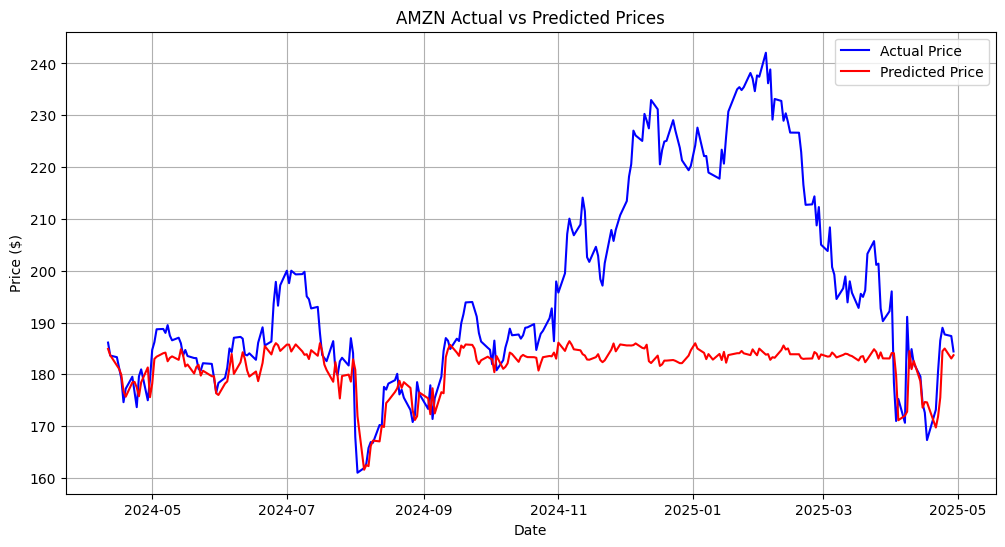

In [9]:
# Plotting the predictions

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label = "Actual Price", color = "blue")
plt.plot(y_test.index, y_pred, label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

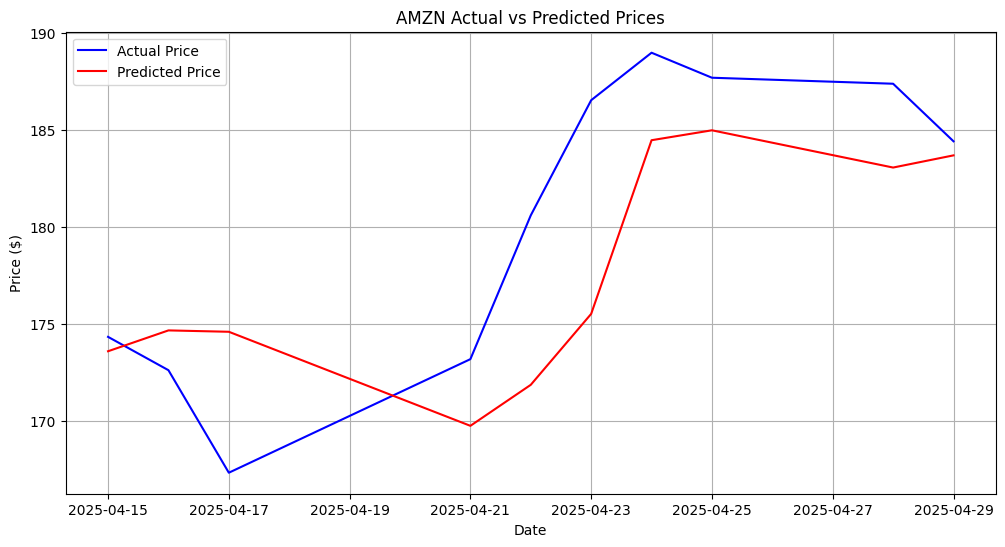

In [10]:
# Last 10 days
plt.figure(figsize=(12,6))
plt.plot(y_test.index[-10:], y_test[-10:], label = "Actual Price", color = "blue")
plt.plot(y_test.index[-10:], y_pred[-10:], label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

The results for XGBoost are not as expected. However, parameter tuning can help us achieve a lower mse.

In [11]:
results_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_comparison.tail()

,Actual,Predicted
Date,,
2025-04-23,186.539993,175.515472
2025-04-24,188.990005,184.475693
2025-04-25,187.699997,184.987350
2025-04-28,187.389999,183.065567
2025-04-29,184.419998,183.693909


In [12]:
print(f"The RMSE of this model is {np.sqrt(mse):.2f}")
print(f"The R2-score of this model is {r2:.2f}")

The RMSE of this model is 22.17
The R2-score of this model is -0.35


In [13]:
def findBestNumEstimators(models, n_estimator_list, depth_list, eta_list, feature_pct_list):
    mse_list = []
    best_mse = 100000000

    for n in n_estimator_list: 
        for d in depth_list:
            for lr in eta_list:
                for f in feature_pct_list:
                    key = f"ne_{n}, depth_{d}, eta_{lr}, features_{f}"
                    models[key] = XGBRegressor(random_state = 1000, n_estimators = n, max_depth = d, eta = lr, colsample_bytree = f)
                    models[key].fit(X_train, y_train)
                    y_pred = models[key].predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    mse_list.append(mse)
                    if  mse < best_mse:
                        best_mse = mse
                        best_model_key = key
                        best_pred = y_pred

    return best_model_key, best_mse, mse_list, best_pred
    


In [14]:
models = dict()
n_estimator_list = [50, 100, 500, 1000, 2000]
depth_list = [1,3,5,8]
learning_rate = [ 0.1, 0.2, 0.3, 0.5]
feature_pct = [0.5, 0.7, 1]


best_model, best_mse, mse_list, best_pred= findBestNumEstimators(
    models,
    n_estimator_list, depth_list, learning_rate, feature_pct
)
print(f"The best model is {best_model} with an RMSE of {np.sqrt(best_mse):.2f}")

The best model is ne_50, depth_8, eta_0.5, features_1 with an RMSE of 21.17


https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

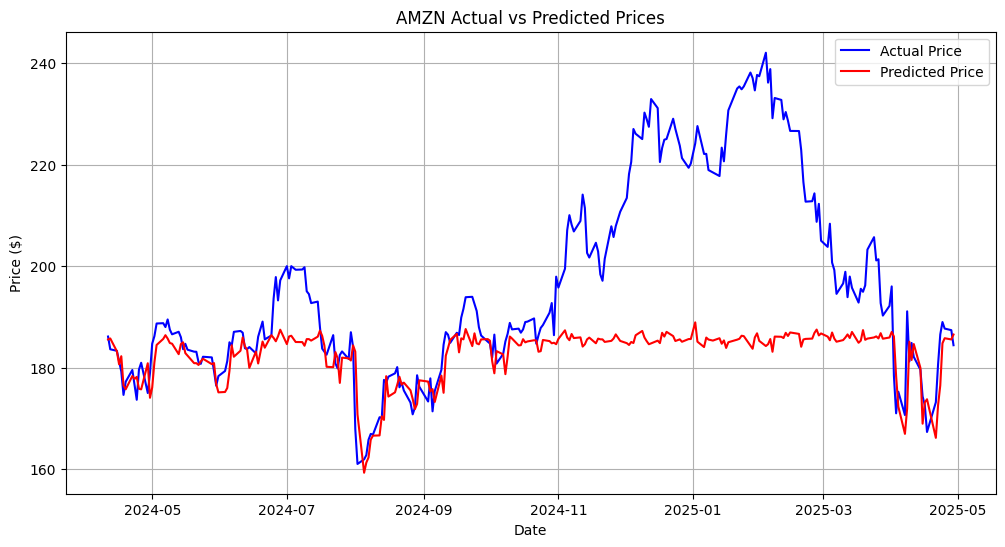

In [15]:
# Plotting the predictions
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label = "Actual Price", color = "blue")
plt.plot(y_test.index, best_pred, label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(f"The RMSE of the best XGBoost model is {np.sqrt(best_mse):.2f}")

train_pred = models[best_model].predict(X_train)
training_accuracy = mean_squared_error(y_train, train_pred)
print(f"The RMSE of the trianing data is {np.sqrt(training_accuracy):.2f}")

The RMSE of the best XGBoost model is 21.17
The RMSE of the trianing data is 0.10


I believe XGBoost is an extremely powerful tool. However, based on these results we can see that even the best values for XGBoost are overfitting the data. This is proof that there is more to be learned about XGBoost Hyperparameter tuning, and about time series in general. 

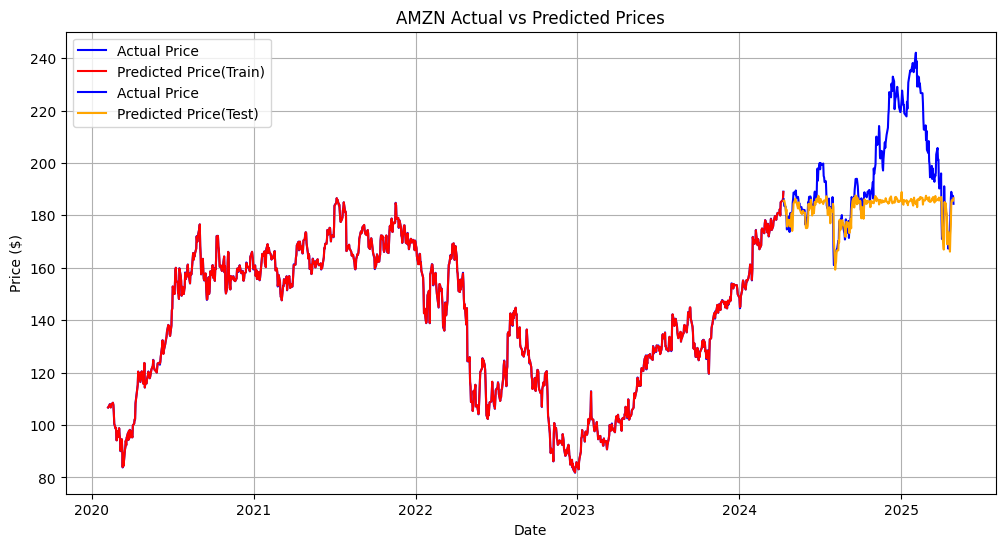

In [17]:
# Plotting the predictions(training and testing data)
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label = "Actual Price", color = "blue")
plt.plot(y_train.index, train_pred, label = "Predicted Price(Train)", color = "red")
plt.plot(y_test.index, y_test, label = "Actual Price", color = "blue")
plt.plot(y_test.index, best_pred, label = "Predicted Price(Test)", color = "orange")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

### Update
In this second part we will attempt to add features to get a better MSE

In [19]:
amzn.head()

Price,Close,High,Low,Open,Volume,SMA_5,EMA_5,MACD,Return,Volatility_5,Target,Lag_1,Lag_2
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,
Date,,,,,,,,,,,,,
2020-02-07,103.963997,104.926498,101.904999,102.099503,101906000,102.232498,101.847784,1.697608,0.014169,1.349681,106.695503,102.511497,101.993500
2020-02-10,106.695503,106.779999,104.248001,104.250504,101124000,103.529599,103.463691,2.282830,0.026274,1.917167,107.540001,103.963997,102.511497
2020-02-11,107.540001,109.297501,106.800003,107.544998,114920000,104.540900,104.822461,2.957221,0.007915,2.478783,108.000000,106.695503,103.963997
2020-02-12,108.000000,109.012497,107.764503,108.160004,66686000,105.742200,105.881641,3.844676,0.004277,2.389455,107.493500,107.540001,106.695503
2020-02-13,107.493500,108.514000,107.099998,107.249496,60636000,106.738600,106.418927,4.613266,-0.004690,1.620457,106.743500,108.000000,107.540001


Importing new libraries that will help us improve the model

In [25]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

We will use the Augmented Dickey-Fuller test to check for stationarity

In [37]:
adfullerResult = adfuller(amzn['Close'])
print('ADF Statistic: %f' % adfullerResult[0])
print('p-value: %f' % adfullerResult[1])
print('Critical Values:')
for key, value in adfullerResult[4].items():
	print('\t%s: %.3f' % (key, value))
if (adfullerResult[1] <= 0.05) & (adfullerResult[4]['5%'] > adfullerResult[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

adfullerResult = adfuller(amzn['Return'])
print('ADF Statistic: %f' % adfullerResult[0])
print('p-value: %f' % adfullerResult[1])
print('Critical Values:')
for key, value in adfullerResult[4].items():
	print('\t%s: %.3f' % (key, value))
if (adfullerResult[1] <= 0.05) & (adfullerResult[4]['5%'] > adfullerResult[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -1.873009
p-value: 0.344863
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic: -37.705779
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


We can see with the ADF test that the values are Closing value is not stationary but the returns (technically the first derivative) is stationary, which suggests that we should add variables related to stationarity.

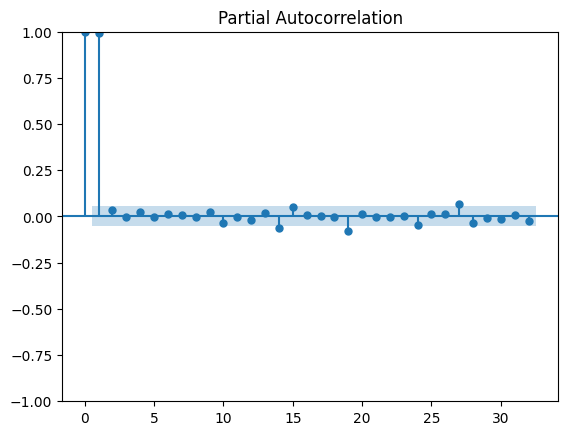

In [38]:
plot_pacf(amzn['Close'], method='ywm')
plt.show()

The PACF Plot shows there is strong autocorrelation only with the previous day.